In [13]:

import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import imblearn as imb
# print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from rdkit import Chem
from rdkit.Chem import Draw
import sys
sys.path.append('../')
# import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
from RF_GSCV import *
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from imblearn.under_sampling import RandomUnderSampler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
split_path = "/Users/radhi/Desktop/CAPSTONE_DATA/NEK_data_4Berkeley/NEK5" 
train_x_df = pd.read_csv(split_path+"/NEK5_binding_random_fold1_trainX.csv")
train_y_df= pd.read_csv(split_path+"/NEK5_binding_random_fold1_trainY.csv")
test_x_df= pd.read_csv(split_path+"/NEK5_binding_random_fold1_testX.csv")
test_y_df= pd.read_csv(split_path+"/NEK5_binding_random_fold1_testY.csv")
train_x = torch.from_numpy(train_x_df.to_numpy())
train_y = torch.from_numpy(train_y_df.to_numpy().reshape(-1))
test_x = torch.from_numpy(test_x_df.to_numpy())
test_y = torch.from_numpy(test_y_df.to_numpy().reshape(-1))

In [15]:
# # Scale data
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# # Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_x = scaling.transform(train_x_df)
test_x = scaling.transform(test_x_df) 

undersample = RandomUnderSampler()
train_x_temp, train_y_temp = undersample.fit_resample(train_x, train_y_df)
train_x = train_x_temp
train_y = train_y_temp.to_numpy().flatten()
test_y = test_y_df.to_numpy().flatten()

In [16]:
# # back to df for saving 
train_x_df = pd.DataFrame(train_x) 
train_y_df = pd.DataFrame(train_y) 
test_y_df = pd.DataFrame(test_y)

train_x_df.to_csv(split_path+'bind_train_x_UNDER.csv', index=False, header=False)
train_y_df.to_csv(split_path+'bind_train_y_UNDER.csv', index=False, header=False) 
test_y_df.to_csv(split_path+'bind_test_y_UNDER.csv', index=False, header=False) 
test_x_df.to_csv(split_path+'bind_test_x_UNDER.csv', index=False, header=False)

In [17]:
train_x_df = pd.read_csv(split_path+'bind_train_x_UNDER.csv')
train_y_df= pd.read_csv(split_path+'bind_train_y_UNDER.csv')
test_x_df= pd.read_csv(split_path+'bind_test_x_UNDER.csv')
test_y_df= pd.read_csv(split_path+'bind_test_y_UNDER.csv')

train_x = train_x_df.to_numpy()
train_y = train_y_df.to_numpy().reshape(-1)
test_x = test_x_df.to_numpy()
test_y = test_y_df.to_numpy().reshape(-1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((153, 306), (153,), (247, 306), (247,))

In [18]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
# from sklearn 0.19.2 documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
# Construct a RF classification model

# creating a RF classifier
clf = BalancedRandomForestClassifier()  
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(train_x, train_y)
 
# performing predictions on the test dataset
train_pred_y = clf.predict(train_x)
test_pred_y = clf.predict(test_x)


/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silenc

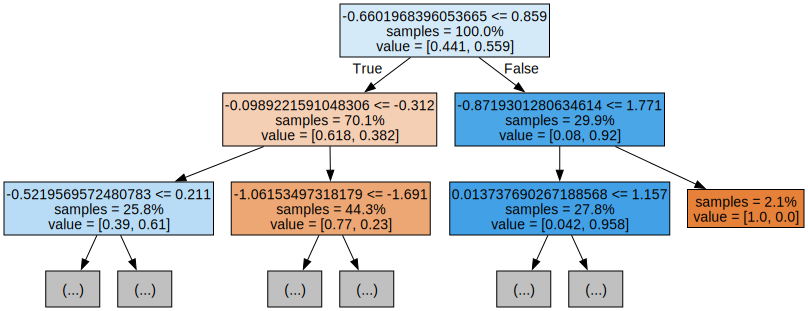

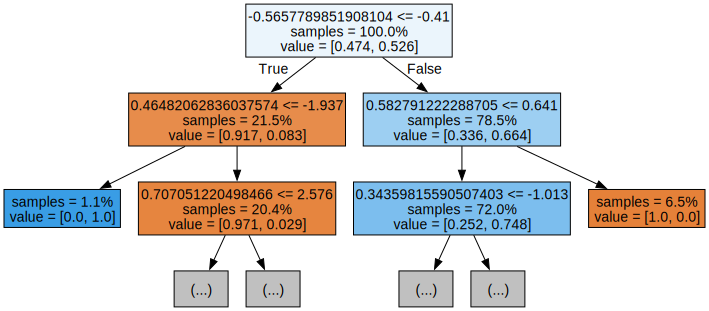

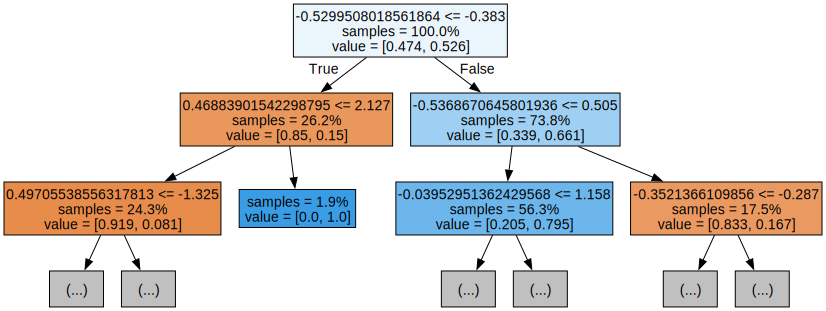

In [20]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = clf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=train_x_df.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Confusion matrix, without normalization
[[76  0]
 [ 0 77]]


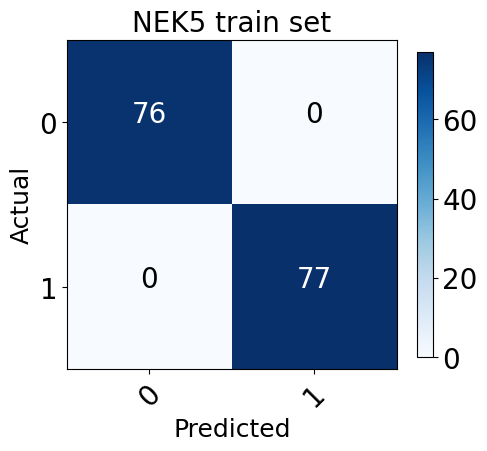

In [23]:
# Create the confusion matrix
train_cm = confusion_matrix(train_y, train_pred_y)

class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK5 train set",fontsize=20)
plot_confusion_matrix(train_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);
plt.show()


Confusion matrix, without normalization
[[121 106]
 [ 15   5]]


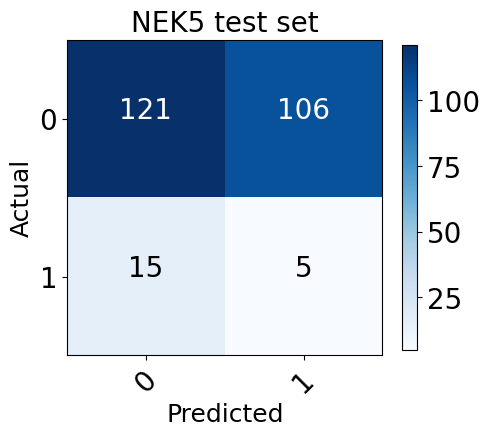

In [24]:
test_cm = confusion_matrix(test_y, test_pred_y)

class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK5 test set",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);
plt.show()